In [256]:
#general tools
from dateutil.parser import parse 
from pandas import DataFrame
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
import datetime
import holidays

#for random forest
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

#for xgboost
import xgboost as xgb

#for lightgbm
import lightgbm as lgb

## Read Data from train.csv

In [1961]:
train = pd.read_csv('train.csv')

In [1962]:
train['date'] = pd.to_datetime(train['date'])
train['year'] = pd.DatetimeIndex(train['date']).year
train['month'] = pd.DatetimeIndex(train['date']).month
train['day'] = pd.DatetimeIndex(train['date']).day
train['hour'] = pd.DatetimeIndex(train['date']).hour
train['dayofyear'] = pd.DatetimeIndex(train['date']).dayofyear
train['weekofyear'] = pd.DatetimeIndex(train['date']).weekofyear
train['weekday'] = pd.DatetimeIndex(train['date']).weekday
train['quarter'] = pd.DatetimeIndex(train['date']).quarter

## Explore data in train.csv

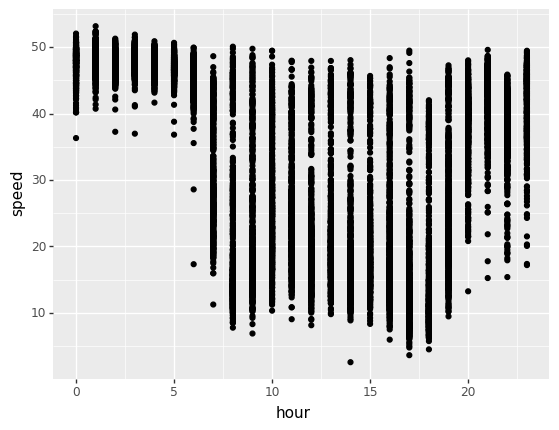

<ggplot: (8779715639926)>

In [1354]:
#find the relationship between speed and hour
ggplot(train, aes(x='hour', y='speed')) + geom_point()

## Handle data in train.csv

In [1963]:
train['date'] = train['date'].dt.strftime('%d.%m.%Y')

In [1964]:
#check if the time belongs to peak hour
def peak(x):
    peak = [7,8,9,10,17,18,19,20]
    if x in peak:
        return '1'
    else:
        return '0'
train['time_peak'] = train['hour'].apply(peak).astype(int)    

In [1965]:
#check if the day belongs to Saturday and Sunday
def weekend(x):
    weekend = [5,6]
    if x in weekend:
        return '1'
    else:
        return '0'
train['weekend'] = train['weekday'].apply(weekend).astype(int)        

In [1966]:
hk_holiday = []    
for date in holidays.HongKong(years=2017).items():
    hk_holiday.append(str(date[0]))
for date in holidays.HongKong(years=2018).items():    
    hk_holiday.append(str(date[0]))

In [1967]:
train['is_holiday'] = [
    1 if str(val).split()[0] in hk_holiday else 0 for val in train['date']
]    

In [1968]:
train = train.drop(['date'], axis = 1) 
train = train.drop(['id'], axis = 1) 

## Split into train and test

In [1969]:
X_train,X_test,y_train,y_test=train_test_split(train.drop('speed', axis = 1), train.speed, test_size=0.2, random_state = 1)

## Read Data from test.csv

In [1970]:
test = pd.read_csv('test.csv')

In [1971]:
test['date'] = pd.to_datetime(test['date'])
test['year'] = pd.DatetimeIndex(test['date']).year
test['month'] = pd.DatetimeIndex(test['date']).month
test['day'] = pd.DatetimeIndex(test['date']).day
test['hour'] = pd.DatetimeIndex(test['date']).hour
test['dayofyear'] = pd.DatetimeIndex(test['date']).dayofyear
test['weekofyear'] = pd.DatetimeIndex(test['date']).weekofyear
test['weekday'] = pd.DatetimeIndex(test['date']).weekday
test['quarter'] = pd.DatetimeIndex(test['date']).quarter

In [1972]:
test['date'] = test['date'].dt.strftime('%d.%m.%Y')

In [1973]:
test['time_peak'] = test['hour'].apply(peak).astype(int)    

In [1974]:
test['weekend'] = test['weekday'].apply(weekend).astype(int)        

In [1975]:
test['is_holiday'] = [
    1 if str(val).split()[0] in hk_holiday else 0 for val in test['date']
] 

In [1976]:
test = test.drop(['date'], axis = 1) 
test = test.drop(['id'], axis = 1) 

## Model

### Random Forest Regressor

#### 1st

In [1293]:
model_rf = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=1, max_features="auto")
model_rf.fit(X_train, y_train) 
pred_test_rf= model_rf.predict(X_test)
print(mean_squared_error(pred_test_rf,y_test))

21.201536533157462


### xgboost

In [1977]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 1, scale_pos_weight=1,
                          learning_rate = 0.05, max_depth = 500, alpha = 10, 
                          n_estimators = 1000, subsample =0.88)
xg_reg.fit(X_train,y_train)
pred_test_xgb = xg_reg.predict(X_test)
print(mean_squared_error(pred_test_xgb,y_test))

13.2409374363656


Feature: 0, Score: 0.04478
Feature: 1, Score: 0.04817
Feature: 2, Score: 0.05420
Feature: 3, Score: 0.64873
Feature: 4, Score: 0.03167
Feature: 5, Score: 0.03150
Feature: 6, Score: 0.12731
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.01365
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000


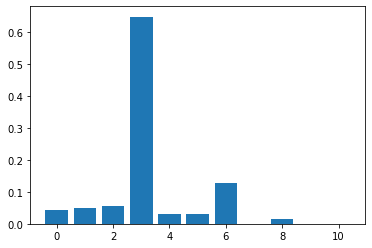

In [1978]:
#check for importance of feature
importance = xg_reg.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [1980]:
pred_xgb=xg_reg.predict(test)

In [1981]:
pred_xgb

array([47.611225, 47.852627, 36.912766, ..., 43.76637 , 39.171448,
       41.297665], dtype=float32)

### Light GMB

In [1913]:
max_depth = 15
lgb_reg = lgb.LGBMRegressor(learning_rate = 0.5, max_depth = 15, num_leaves = 50, feature_fraction = 0.9, n_estimators = 100)
lgb_reg.fit(X_train,y_train)
pred_test_lgb = lgb_reg.predict(X_test)
print(mean_squared_error(pred_test_lgb,y_test))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
17.360071786872705


In [1057]:
prob_test_lgb = lgb_model.predict(X_test)
print(mean_squared_error(pred_test_xgb,y_test))

## Write data to file

In [1982]:
prediction_xgb = pd.DataFrame(pred_xgb, columns=['speed']).to_csv('xgb.csv')